In [1]:
import boto3
import io
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import ast
import shapefile
import matplotlib.pyplot as plt
import seaborn as sns
from amazon_keys import AWSAccessKeyId, AWSSecretKey
import change_dir

today = datetime.now(timezone.utc)
client = boto3.client(
    's3',
    aws_access_key_id= AWSAccessKeyId,
    aws_secret_access_key= AWSSecretKey,
    
)

#create a bucket
#client.create_bucket(Bucket = 'car-crashes-bucket')

# see the list of current buckets

bucket_list = client.list_buckets()

bucket_names = [bucket['Name'] for bucket in bucket_list['Buckets']]

bucket_names

#how to extract data from the buckets

objects = client.list_objects(Bucket= 'corona-experiments')

file_dict = {}
file_names = []
file_times = []
for o in objects["Contents"]:
    file_names.append(o["Key"])
    file_times.append(o["LastModified"])
        #file_dict.update(dict(item = o["Key"],time = o["LastModified"]))
        #print(dict(item = o["Key"],time = o["LastModified"]))
file_dict.update(dict(file_name = file_names,last_modified = file_times))

file_df = pd.DataFrame(file_dict)

#this allows me to get only those objects that are in the data/nys directory and contain _v2 in file name
# I have restricted the selection to the latest covid data from the nys data source
##### nys data
nys_infections = file_df[(file_df['file_name'].str.contains('data/nys/')) & (file_df['file_name'].str.contains('_v2'))]
nys_infections['last_modified'] = pd.to_datetime(nys_infections['last_modified'])
nys_infections_latest_file = nys_infections[nys_infections['last_modified'] == nys_infections['last_modified'].max()]

#this gives me the geodata for all us zip codes. the sources is the us census bureau 

fp = 'data/tl_2018_us_zcta510/tl_2018_us_zcta510.shp'
#map_df = gpd.read_file(fp)
counties_usa_shape = gpd.read_file(fp)
counties_usa_shape.columns = counties_usa_shape.columns.str.lower()

counties_usa_shape.head()

# the latest nyc data by zip code
# the source is the nyc doh
cases_nyc_zip = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/master/tests-by-zcta.csv')
cases_nyc_zip = cases_nyc_zip[~cases_nyc_zip['MODZCTA'].isnull()]
cases_nyc_zip['date'] = pd.to_datetime('today').date()

cases_nyc_zip.head()

#removing the null zipcodes
cases_nyc_zip = cases_nyc_zip[~cases_nyc_zip['MODZCTA'].isnull()]
nyc_zip_list = list(cases_nyc_zip['MODZCTA'])

# this gives me the geo data for the nyc counties that have been affected by covid
counties_usa_shape['zcta5ce10'] = counties_usa_shape['zcta5ce10'].astype('float')
nyc_counties_geodata = counties_usa_shape[counties_usa_shape['zcta5ce10'].isin(nyc_zip_list)]

# adding the covid info to the geo data
map_zip = pd.merge(nyc_counties_geodata,cases_nyc_zip, how ='left', left_on = 'zcta5ce10', right_on = 'MODZCTA')
map_zip.head()



# source : the us census bureau
household_income = pd.read_csv('data/ACSST5Y2018.S1901_data_with_overlays_2020-04-02T191540.csv')

household_income = household_income[['GEO_ID','NAME','S1901_C01_001E','S1901_C01_013E']]
household_income['NAME'] = household_income['NAME'].str.extract('(\d{5})')
household_income.rename(columns ={'GEO_ID':'geo_id','NAME':'zip_code','S1901_C01_013E':'household_mean_income','S1901_C01_001E':'household_number'}, inplace = True)
#I changed the zip to float to match the the datatype in the geo dataframe. It might be better to have zip as string, eventhough I do not thing that any info is lost
# by changing it to float
household_income['zip_code'] = household_income['zip_code'].astype('float')
household_income.head()

# getting the household income  from only nyc zip codes 
nyc_household_income= household_income[household_income['zip_code'] .isin(nyc_zip_list)]
nyc_household_income.head()

# i added the income info to the geo data
map_zip_2 = pd.merge(map_zip,nyc_household_income, how ='left', left_on = 'zcta5ce10', right_on = 'zip_code')

map_zip_2.drop(columns = ['geoid10','MODZCTA','Total','zcta_cum.perc_pos','zip_code'], axis = 1, inplace = True)


#################################################################################### data sets
##### nys numbers
key = list(nys_infections_latest_file['file_name'])[0]
obj = client.get_object(Bucket='corona-experiments', Key= key)
data = obj['Body'].read()
infections_nys_county_all_time = pd.read_csv(io.BytesIO(data), encoding='utf-8')
# 03/18/2020 had a lot of missing data that is why I am removing it
infections_nys_county_all_time = infections_nys_county_all_time[infections_nys_county_all_time['test_date'] != '2020-03-18']
#####
infections_nys_county_latest = infections_nys_county_all_time[infections_nys_county_all_time['test_date'] == infections_nys_county_all_time['test_date'].max()]


#### nyc numbers by county
nyc = ['Bronx','Kings','Richmond','Queens','New York']

infections_nyc_all_time = infections_nys_county_all_time[infections_nys_county_all_time['county'].isin(nyc)]

infections_nyc_latest = infections_nyc_all_time[infections_nyc_all_time['test_date'] == infections_nyc_all_time['test_date'].max()]

infections_nyc_latest

infections_nyc_all_time_sum = infections_nyc_all_time.groupby(['test_date'], as_index = False).sum()

print('done')

done


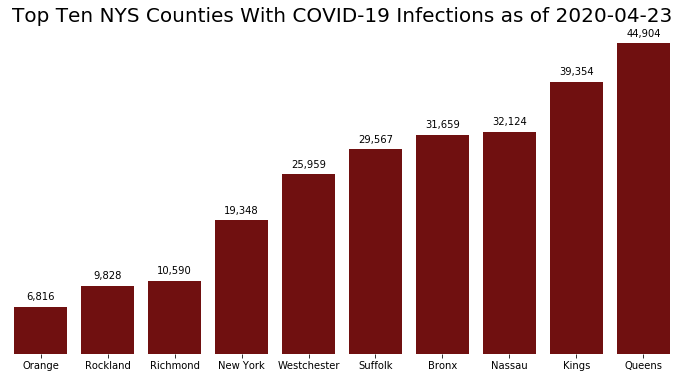

In [4]:
today = pd.to_datetime('today').date()
top_ten_counties = infections_nys_county_latest.sort_values('cumulative_number_of_positives', ascending = False).head(10)

top_ten_counties = top_ten_counties.sort_values('cumulative_number_of_positives', ascending = True)

plt.figure(figsize = (12,6))

ax = sns.barplot(x = top_ten_counties['county'], y = top_ten_counties['cumulative_number_of_positives'], color = 'maroon')

plt.title(f'Top Ten NYS Counties With COVID-19 Infections as of {today}', fontsize = 20)

plt.xlabel('')
plt.ylabel('')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax.get_yaxis().set_ticks([])

# these get rid of the borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
    

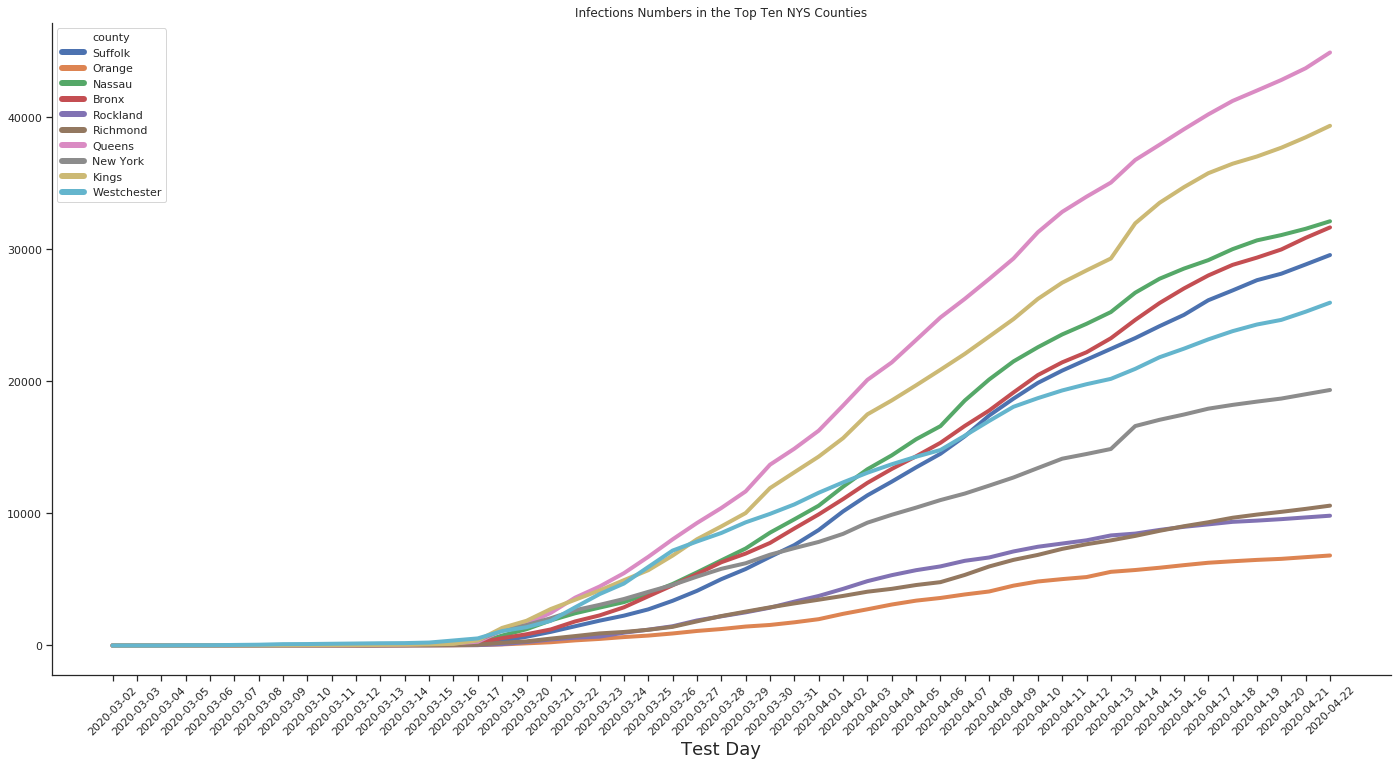

In [6]:
#top ten over time

top_ten_alltime = infections_nys_county_all_time[infections_nys_county_all_time['county'].isin(list(top_ten_counties['county']))]
top_ten_alltime.sort_values(by = 'cumulative_number_of_positives', inplace = True)
plt.figure(figsize = (24,12))

sns.set(style="ticks", rc={"lines.linewidth": 4})

ax = sns.lineplot(x="test_date", y="cumulative_number_of_positives",

                     hue="county", 

                     data= top_ten_alltime)


# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 20)

leg = ax.legend()

for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.title('Infections Numbers in the Top Ten NYS Counties')
plt.xticks(rotation = 45)
plt.xlabel('Test Day', fontsize = 18)
plt.ylabel('', fontsize = 18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax

No handles with labels found to put in legend.
No handles with labels found to put in legend.


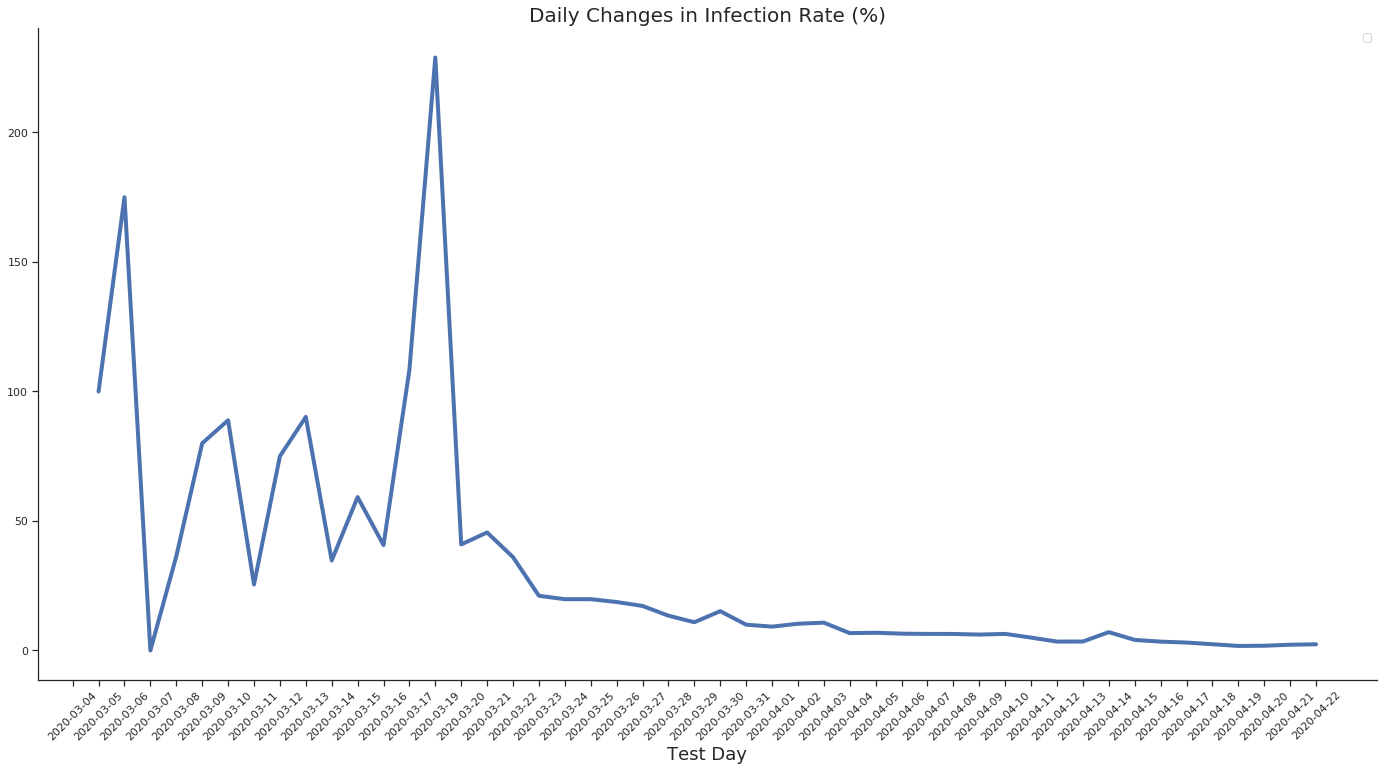

In [7]:
############################################################################### changes in infection rate ###########################################################################################
infections_nyc_all_time_sum['percent_change_positives'] = round((infections_nyc_all_time_sum['cumulative_number_of_positives'].pct_change()) *100,2)

top_ten_alltime.sort_values(by = 'cumulative_number_of_positives', inplace = True)
plt.figure(figsize = (24,12))

sns.set(style="ticks", rc={"lines.linewidth": 4})

ax = sns.lineplot(x="test_date", y="percent_change_positives",

                     data= infections_nyc_all_time_sum)


# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 20)

leg = ax.legend()

for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.title('Daily Changes in Infection Rate (%)', fontsize = 20)
plt.xticks(rotation = 45)
plt.xlabel('Test Day', fontsize = 18)
plt.ylabel('', fontsize = 18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax

No handles with labels found to put in legend.


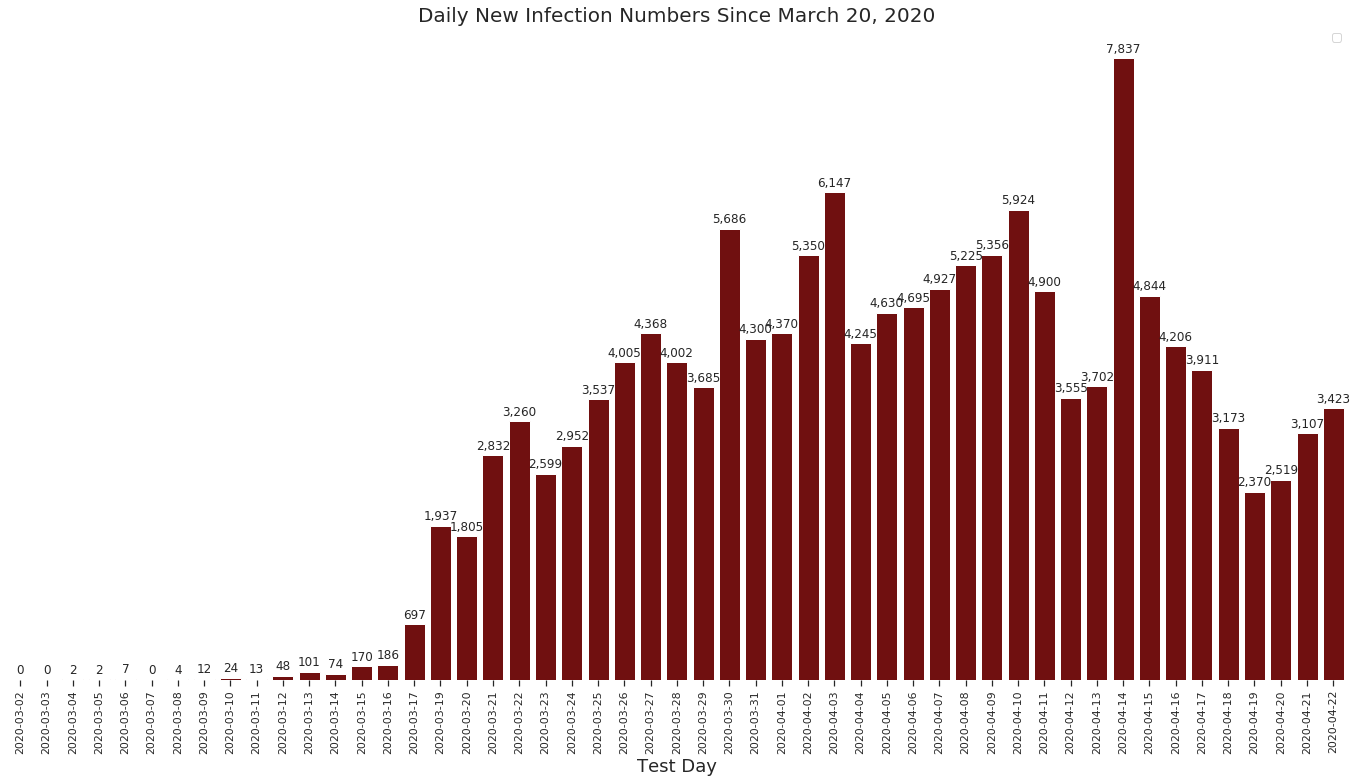

In [8]:
top_ten_alltime.sort_values(by = 'cumulative_number_of_positives', inplace = True)
plt.figure(figsize = (24,12))

sns.set(style="ticks", rc={"lines.linewidth": 4})

ax = sns.barplot(x="test_date", y="new_positives",

                     data= infections_nyc_all_time_sum,
                color = 'maroon')


# # Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 20)

leg = ax.legend()

for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.title('Daily New Infection Numbers Since March 20, 2020', fontsize = 20)
plt.xticks(rotation = 90)
plt.xlabel('Test Day', fontsize = 18)
plt.ylabel('', fontsize = 18)

ax.get_yaxis().set_ticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# the ',' in format adds the commas. COOL feature
for p in ax.patches:
    ax.annotate(format(p.get_height(),',.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
ax

Text(0.5, 1.0, 'Corona Infections by Zip Code, NYC')

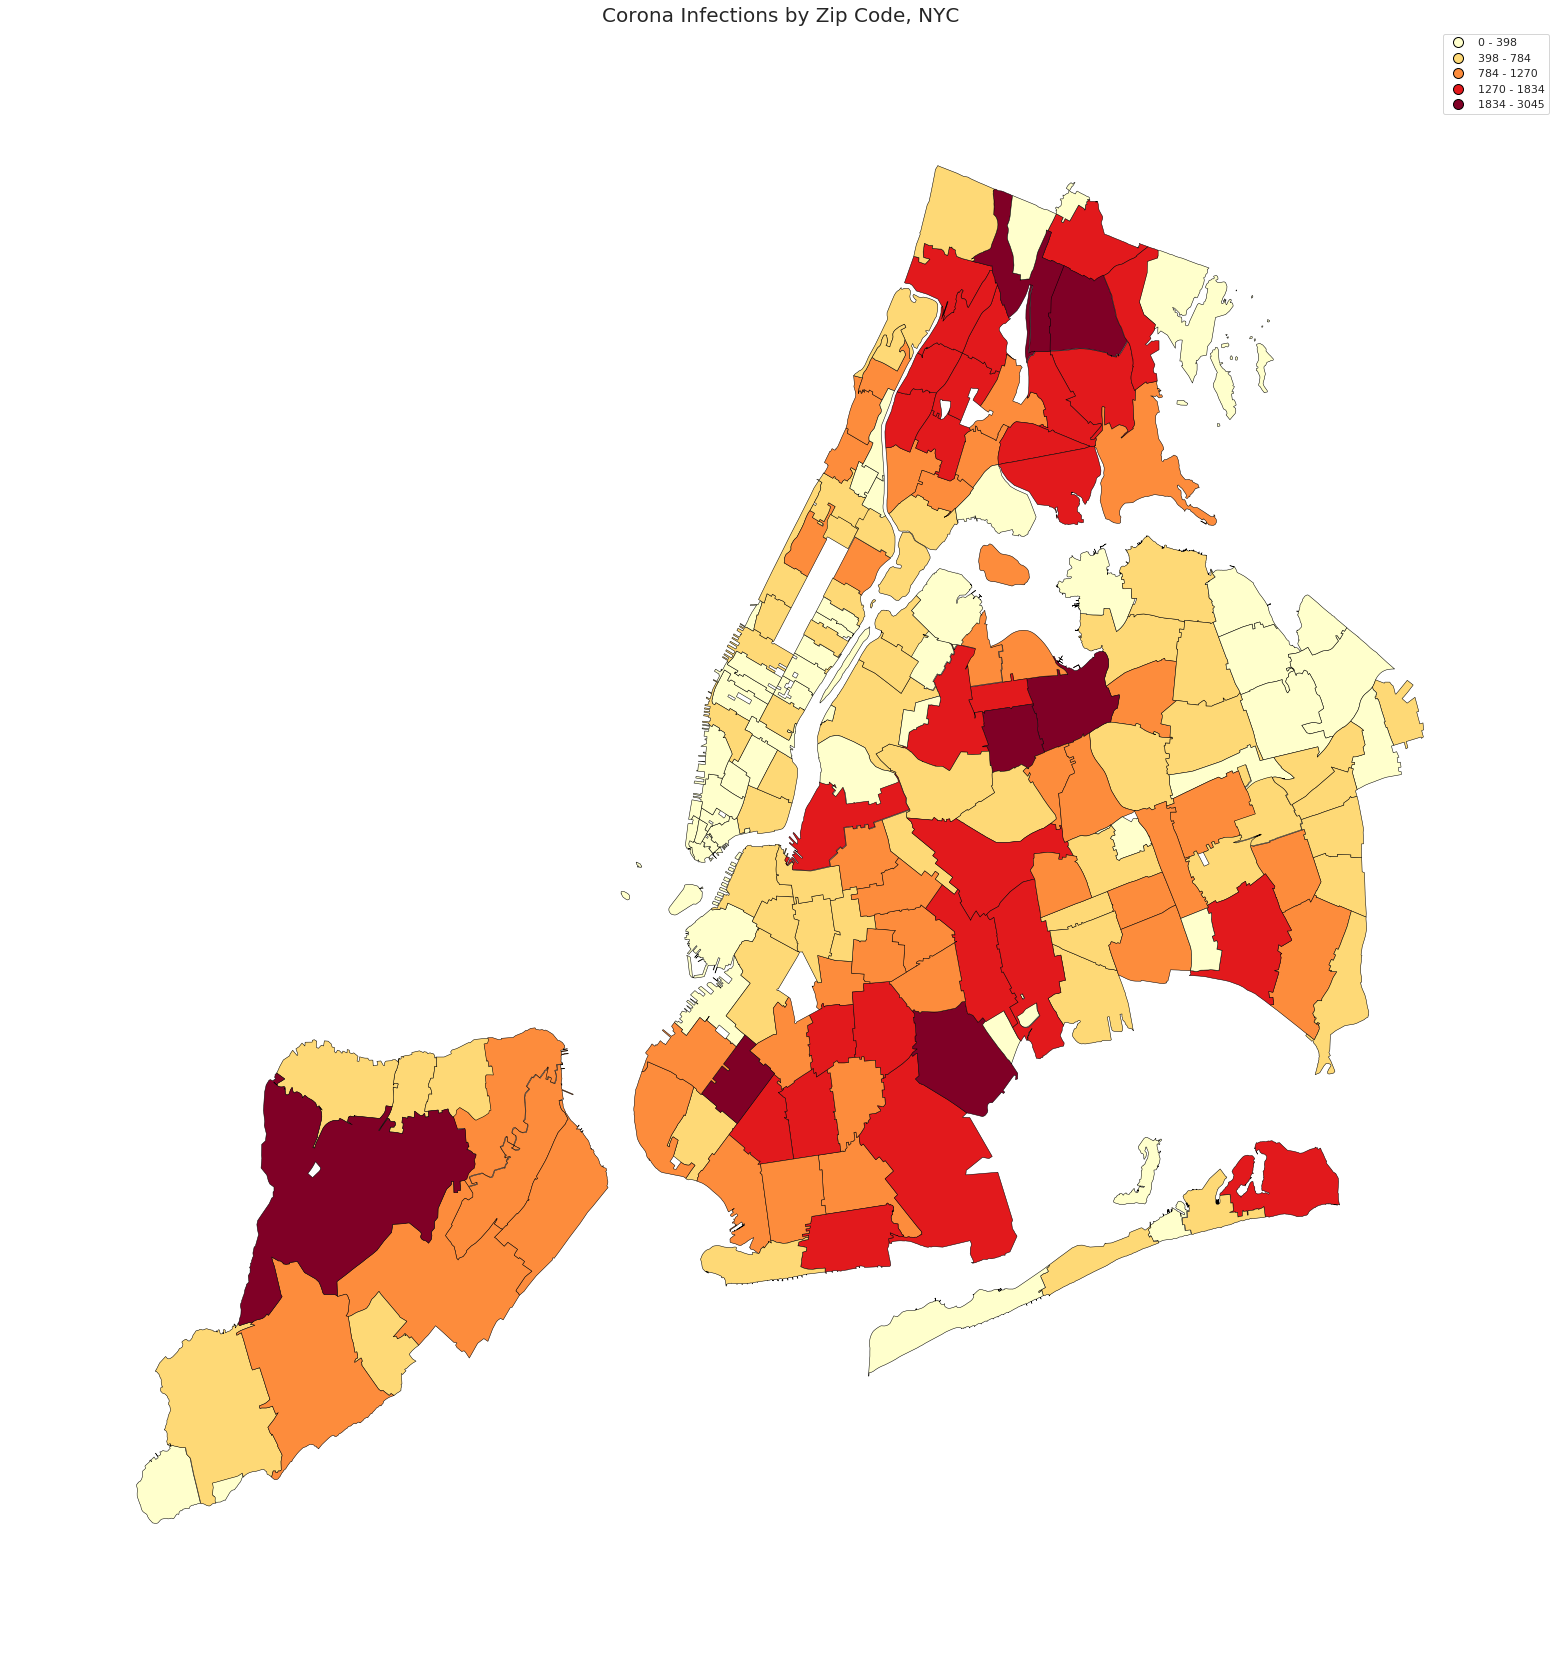

In [9]:

gplt.choropleth(
    map_zip_2, hue='Positive', projection=gcrs.AlbersEqualArea(),
    edgecolor='black', linewidth=0.5,
    cmap='YlOrRd', legend=True,
    scheme='FisherJenks', # this determines how the data is aggregated. See this link for more info http://geopandas.org/reference.html
    figsize = (30,30))


   

plt.title("Corona Infections by Zip Code, NYC", fontsize = 20)


# I still need to fix the legend issue

In [11]:
queens_zip = [11361, 11362, 11363, 11364,
11354, 11355, 11356, 11357, 11358, 11359, 11360,
11365, 11366, 11367,
11412, 11423, 11432, 11433, 11434, 11435, 11436,
11101, 11102, 11103, 11104, 11105, 11106,
11374, 11375, 11379, 11385,
11691, 11692, 11693, 11694, 11695, 11697,
11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428, 11429,
11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421,
11368, 11369, 11370, 11372, 11373, 11377, 11378]


queens_map = map_zip_2[map_zip_2['zcta5ce10'].isin(queens_zip)]

manhattan_zip = [10026, 10027, 10030, 10037, 10039,
10001, 10011, 10018, 10019, 10020, 10036,10029, 10035,
10010, 10016, 10017, 10022, 10012, 10013, 10014,
10004, 10005, 10006, 10007, 10038, 10280,
10002, 10003, 10009, 10021, 10028, 10044, 
10065, 10075, 10128, 10023, 10024, 10025,
10031, 10032, 10033, 10034, 10040
]

manhattan_map = map_zip_2[map_zip_2['zcta5ce10'].isin(manhattan_zip)]

Text(0.5, 1.0, 'Corona Infections by Zip Code, Queens')

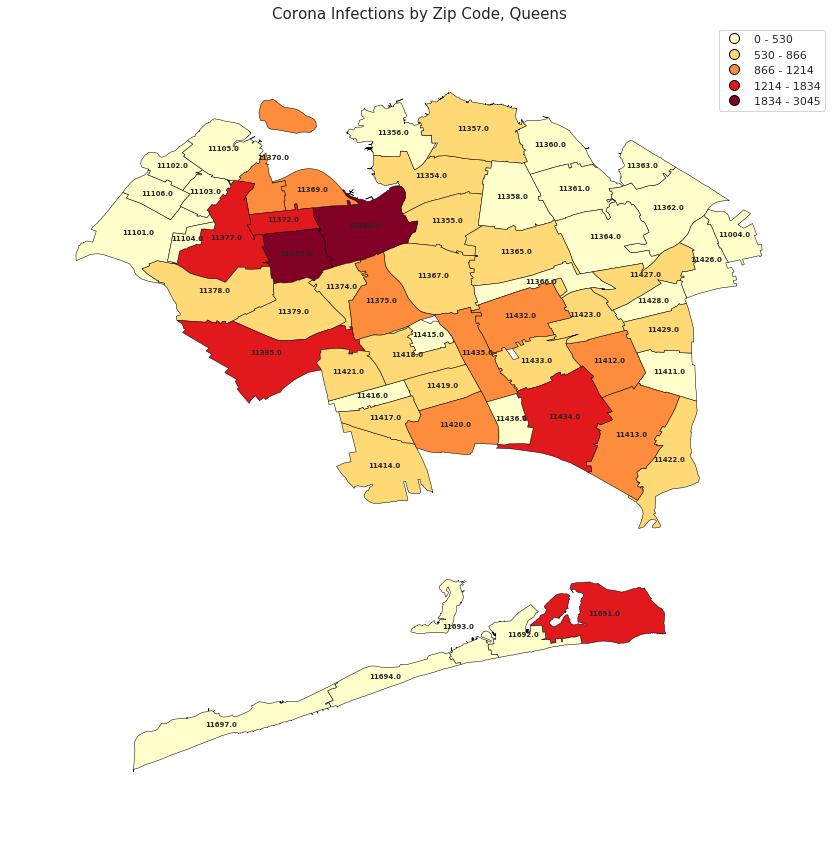

In [12]:
# this creates the coordinates where I am going to place the zip text
queens_map['coords'] = queens_map['geometry'].apply(lambda x: x.centroid.coords[:])
queens_map['coords'] = [coords[0] for coords in queens_map['coords']]
queens_map.head()


gplt.choropleth(
    queens_map, hue='Positive', 
    edgecolor='black', linewidth=0.5,
    cmap='YlOrRd', legend = True,
    scheme='FisherJenks',
    figsize = (15,15))


for _, row in queens_map.iterrows():
    hue = queens_map['Positive']
    plt.text(x = row['coords'][0], y = row['coords'][1],s =row['zcta5ce10'],
        horizontalalignment='center', 
        fontdict = {'weight': 'bold', 'size': 7})

    

plt.title("Corona Infections by Zip Code, Queens", fontsize = 15)


Text(0.5, 1.0, 'Corona Infections by Zip Code, Manhattan')

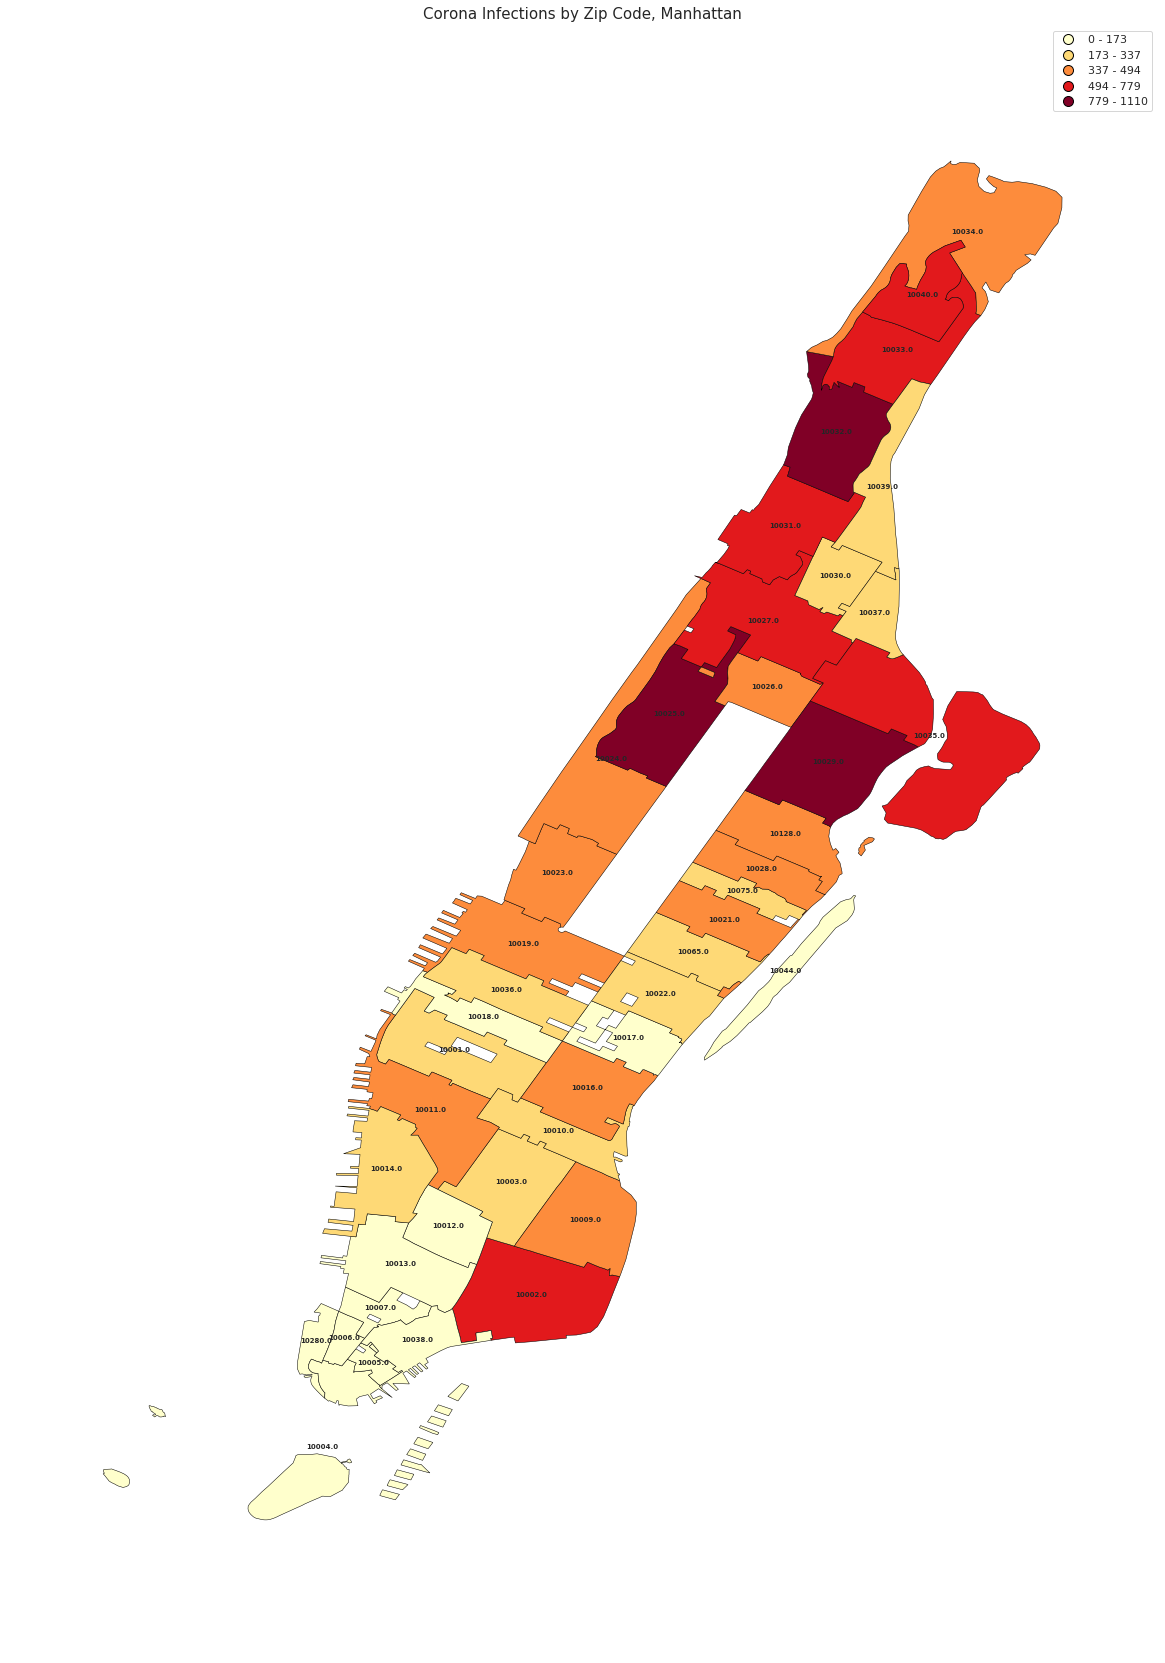

In [10]:
# this creates the coordinates where I am going to place the zip text
manhattan_map['coords'] = manhattan_map['geometry'].apply(lambda x: x.centroid.coords[:])
manhattan_map['coords'] = [coords[0] for coords in manhattan_map['coords']]

gplt.choropleth(
    manhattan_map, hue='Positive', 
    edgecolor='black', linewidth=0.5,
    cmap='YlOrRd', legend = True,
    scheme='FisherJenks',
    figsize = (30,30))


for _, row in manhattan_map.iterrows():
    hue = manhattan_map['Positive']
    plt.text(x = row['coords'][0], y = row['coords'][1],s =row['zcta5ce10'],
        horizontalalignment='center', 
        fontdict = {'weight': 'bold', 'size': 7})

    

plt.title("Corona Infections by Zip Code, Manhattan", fontsize = 15)

In [16]:
who

AWSAccessKeyId	 AWSSecretKey	 ast	 ax	 boto3	 bucket_list	 bucket_names	 cases_nyc_zip	 change_dir	 
client	 counties_usa_shape	 data	 datetime	 file_df	 file_dict	 file_names	 file_times	 fp	 
gcrs	 gpd	 gplt	 household_income	 hue	 infections_nyc_all_time	 infections_nyc_all_time_sum	 infections_nyc_latest	 infections_nys_county_all_time	 
infections_nys_county_latest	 io	 key	 leg	 line	 manhattan_map	 manhattan_zip	 map_zip	 map_zip_2	 
np	 nyc	 nyc_counties_geodata	 nyc_household_income	 nyc_zip_list	 nys_infections	 nys_infections_latest_file	 o	 obj	 
objects	 p	 pd	 plt	 queens_map	 queens_zip	 row	 shapefile	 sns	 
time	 timezone	 today	 top_ten_alltime	 top_ten_counties	 warnings	 


In [10]:

map_zip_2['log_Positive'] = np.log(map_zip_2['Positive']+1)
map_zip_2['log_income'] = np.log(map_zip_2['household_mean_income'].astype(float)+1)

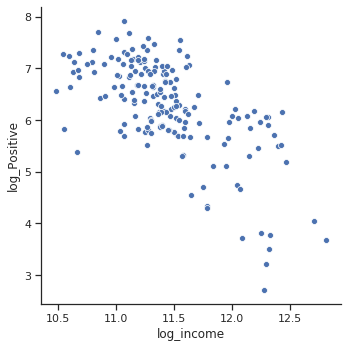

In [11]:
sns.relplot(y="log_Positive", x= "log_income", data= map_zip_2)

In [26]:
map_zip_2['household_mean_income'].dtype

dtype('O')